<a href="https://colab.research.google.com/github/vendyliang/MachineLearningProjects/blob/master/Movie_Watch_Time_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Movie Watch Time Forecasting**

In this project, I build a prediction model to forecast whether a movie is going to perform well on our platform in terms of cumulated view time per day (cvt_per_day) with the information in the dataset.

Some highlights in the project:
- Excessive missing values are found and need manipulation before modeling
- Categorical features such as release year and genres are complicated observation that need to be transformed into new features for modeling 
- Linear and non-linear models built and accuracy benchmarked to come up with best model
- Business insights into top factors associated with the dependent variable cvt_per_day with feature importance analysis

The dependent variable of interest is cvt_per_day.

# Content
* Part 1: Data Exploration
* Part 2: Feature Preprocessing
* Part 3: Model Training
* Part 4: Model Evaluation
* Part 5: Feature Selection

# Load Packages

In [0]:
%matplotlib inline
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import seaborn as sns
import sklearn as sl
from sklearn import preprocessing
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 60)

# Load Data

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=1vMUTPkfZOv-m6lQbIFVH65VpNnWMj7IN'
fluff, id = link.split('=')
file = drive.CreateFile({'id':id}) # replace the id with id of file you want to access
file.GetContentFile('MovieData.txt')  

In [0]:
#read the dataset as dataframe with pandas
df1 = pd.read_csv('MovieData.txt')

In [5]:
df1.head()

,video_id,cvt_per_day,weighted_categorical_position,weighted_horizontal_poition,import_id,release_year,genres,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,awards,mpaa,star_category
0,385504,307127.606,1,3,lionsgate,2013,"Action,Thriller,Drama",69614,15000000,42930462,6.500,112.301,51,other award,PG-13,1.710
1,300175,270338.426,1,3,lionsgate,2013,"Comedy,Crime,Thriller",46705,15000000,3301046,6.500,94.983,41,no award,R,3.250
2,361899,256165.867,1,3,other,2012,"Crime,Drama",197596,26000000,37397291,7.300,115.764,58,other award,R,2.647
3,308314,196622.721,3,4,lionsgate,2008,"Thriller,Drama,War,Documentary,Mystery,Action",356339,15000000,15700000,7.600,130.704,94,Oscar,R,1.667
4,307201,159841.652,1,3,lionsgate,2013,"Crime,Thriller,Mystery,Documentary",46720,27220000,8551228,6.400,105.546,37,other award,R,3.067


In [6]:
#correct a typo in the 'weighted_horizontal_position' column
df1 = df1.rename(columns={'weighted_horizontal_poition':'weighted_horizontal_position'})
df1.head()

,video_id,cvt_per_day,weighted_categorical_position,weighted_horizontal_position,import_id,release_year,genres,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,awards,mpaa,star_category
0,385504,307127.606,1,3,lionsgate,2013,"Action,Thriller,Drama",69614,15000000,42930462,6.500,112.301,51,other award,PG-13,1.710
1,300175,270338.426,1,3,lionsgate,2013,"Comedy,Crime,Thriller",46705,15000000,3301046,6.500,94.983,41,no award,R,3.250
2,361899,256165.867,1,3,other,2012,"Crime,Drama",197596,26000000,37397291,7.300,115.764,58,other award,R,2.647
3,308314,196622.721,3,4,lionsgate,2008,"Thriller,Drama,War,Documentary,Mystery,Action",356339,15000000,15700000,7.600,130.704,94,Oscar,R,1.667
4,307201,159841.652,1,3,lionsgate,2013,"Crime,Thriller,Mystery,Documentary",46720,27220000,8551228,6.400,105.546,37,other award,R,3.067


In [7]:
df1.tail()

,video_id,cvt_per_day,weighted_categorical_position,weighted_horizontal_position,import_id,release_year,genres,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,awards,mpaa,star_category
4221,160848,9.726,3,32,other,2010,"Comedy,Drama",14,0,0,7.800,4.312,0,no award,NotRated,1.700
4222,365178,7.913,29,35,other,2013,Music,0,0,0,0.000,4.879,0,no award,PG-13,0.000
4223,11615,2.936,3,27,other,2008,Comedy,505,0,0,7.100,110.350,0,other award,NotRated,0.000
4224,26365,2.867,4,15,other,2003,Documentary,5,100000,0,6.000,79.633,0,no award,NotRated,0.000
4225,11229,2.188,7,35,other,2003,"Drama,Romance",80,0,0,7.600,53.618,0,no award,NotRated,1.750


In [8]:
#use df1.shape to get the dimension of the dataframe
print('Num of rows:', df1.shape[0])
print('Num of columns', df1.shape[1])

Num of rows: 4226
Num of columns 16


There are total 4000 + rows of data with 16 features for this data set.

# Part 1: Data Exploration

## 1.1 Remove erroneous data

Each video should only appear once. Duplicated video ids should be removed.

In [35]:
mask = df1['video_id'].duplicated()
if len(df1['video_id'][mask]) == 0:
  print('There is no duplicated entry (video_id based).')
#booleam masking. return the array with values that satisfy the condition. because all False so return empty array

There is no duplicated entry (video_id based).


## 1.2 Understand numerical data

1.2.1 Overview

In [9]:
#check missing value
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4226 entries, 0 to 4225
Data columns (total 16 columns):
video_id                         4226 non-null int64
cvt_per_day                      4226 non-null float64
weighted_categorical_position    4226 non-null int64
weighted_horizontal_position     4226 non-null int64
import_id                        4226 non-null object
release_year                     4226 non-null int64
genres                           4226 non-null object
imdb_votes                       4226 non-null int64
budget                           4226 non-null int64
boxoffice                        4226 non-null int64
imdb_rating                      4226 non-null float64
duration_in_mins                 4226 non-null float64
metacritic_score                 4226 non-null int64
awards                           4226 non-null object
mpaa                             4226 non-null object
star_category                    4226 non-null float64
dtypes: float64(4), int64(8), obj

There are 12 features represented by numbers and 4 categorical features.
But video_id, release_year are not numerical features although they are represented by numbers.

In [78]:
print(df1.drop(columns = ['video_id', 'release_year']).describe(percentiles=[.1, .25, .5, .75, .9]))
#Note: Change pandas set_option with display columns to show all columns

       cvt_per_day  weighted_categorical_position  \
count     4226.000                       4226.000   
mean      4218.630                          7.783   
std      13036.080                          6.134   
min          2.188                          1.000   
10%        141.985                          3.000   
25%        351.169                          4.000   
50%       1193.500                          6.000   
75%       3356.789                          9.000   
90%       7930.121                         15.000   
max     307127.606                         41.000   

       weighted_horizontal_position  imdb_votes        budget     boxoffice  \
count                      4226.000    4226.000      4226.000      4226.000   
mean                         28.104    6462.924   2150743.439   2536338.472   
std                          11.864   31596.007   7176604.483   8243516.266   
min                           1.000       0.000         0.000         0.000   
10%                  

In [77]:
(df1 == 0).sum()

video_id                            0
cvt_per_day                         0
weighted_categorical_position       0
weighted_horizontal_position        0
import_id                           0
release_year                        0
genres                              0
imdb_votes                        344
budget                           2454
boxoffice                        3194
imdb_rating                       344
duration_in_mins                    0
metacritic_score                 3012
awards                              0
mpaa                                0
star_category                    1846
dtype: int64

In [29]:
print('There are ' + str((df1 == 0).any(axis = 0).sum()) + ' number of columns that have at least 1 missing values')
print('There are ' + str((df1 == 0).any(axis = 1).sum()) + ' number of rows that have at least 1 missing values')

There are 6 number of columns that have at least 1 missing values
There are 3242 number of rows that have at least 1 missing values


In [30]:
#imdb votes, imdb rating, budget, boxoffice, metacritic score, star category have missing values
mv = ['imdb_votes', 'imdb_rating', 'budget', 'boxoffice', 'metacritic_score', 'star_category']
count = 0
for col in mv:
  for row in df1[col]:
    if row == 0:
      count += 1
  print(col, '\t :', count, 'missing values, ', np.floor((count/df1.shape[0])*100), '% of total data points' )
  count = 0

imdb_votes 	 : 344 missing values,  8.0 % of total data points
imdb_rating 	 : 344 missing values,  8.0 % of total data points
budget 	 : 2454 missing values,  58.0 % of total data points
boxoffice 	 : 3194 missing values,  75.0 % of total data points
metacritic_score 	 : 3012 missing values,  71.0 % of total data points
star_category 	 : 1846 missing values,  43.0 % of total data points


Among the 10 numerical features (not include video_id and release_year), 4 features have over 45% of missing data: budget, boxoffice, metacritic_score, star_category. 2 features have less than 10% of missing data: imdb_votes, imdb_rating. In this assessment, I will assume that all cells with 0 values are missing values, not informative missing.

1.2.2 Understand distribution of numerical features
- Cumulated view time per day is the feature we forecast (cvt_per_day)
- Other features, such as budget, weighted_categorical_position, duration_in_mins


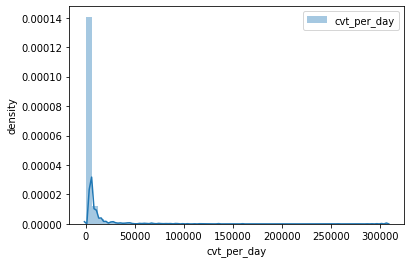

In [38]:
sns.distplot(df1['cvt_per_day'], label = 'cvt_per_day')
plt.legend(loc = 'upper right')
plt.ylabel('density')
plt.show()

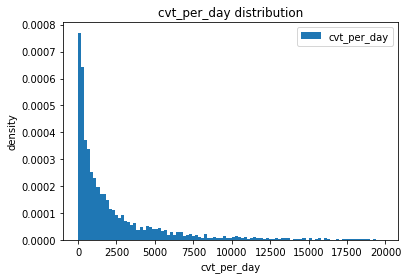

In [49]:
#draw a histogram for 'cvt_per_day' with range (0, 20000)

plt.hist(df1['cvt_per_day'].values, bins = range(0, 20000, 200), label = 'cvt_per_day', density = True)
plt.legend(loc = 'upper right')
plt.xlabel('cvt_per_day')
plt.ylabel('density')
plt.title('cvt_per_day distribution')
plt.show()

#bins = range(0, 20000, 200) is optimized from bins = 200, range = (0, 20000)

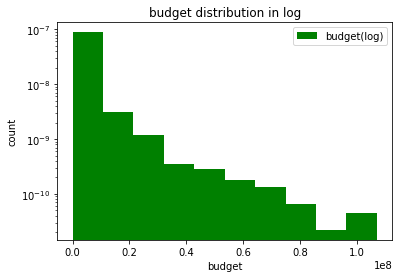

In [51]:
#draw a histogram for 'budget'

plt.hist(df1['budget'].values, density = True, log = True, label = 'budget(log)', color = 'g')
plt.legend(loc = 'upper right')
plt.xlabel('budget')
plt.ylabel('count')
plt.title('budget distribution in log')
plt.show()

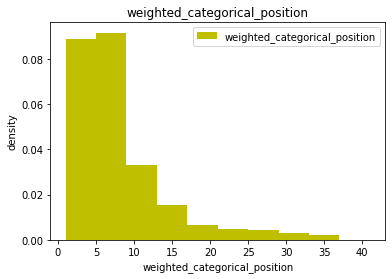

In [56]:
#draw a histogram for 'weighted_categorical_position'

plt.hist(df1['weighted_categorical_position'], density = True, label = 'weighted_categorical_position', color = 'y')
plt.legend(loc = 'upper right')
plt.xlabel('weighted_categorical_position')
plt.ylabel('density')
plt.title('weighted_categorical_position')
plt.show()

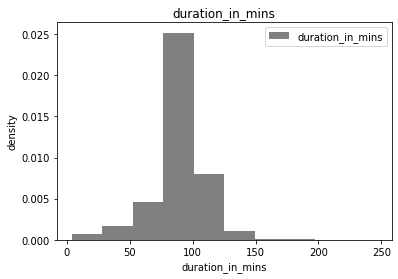

In [57]:
#draw a histogram for 'duration_in_mins'

plt.hist(df1['duration_in_mins'].values, density = True, label = 'duration_in_mins', color = 'grey')
plt.legend(loc = 'upper right')
plt.xlabel('duration_in_mins')
plt.ylabel('density')
plt.title('duration_in_mins')
plt.show()

1.2.3 Correlation among numerical features

In [0]:
corr = df1[['cvt_per_day', 'weighted_categorical_position',
       'weighted_horizontal_position', 'release_year',
       'imdb_votes', 'budget', 'boxoffice', 'imdb_rating', 'duration_in_mins',
       'metacritic_score', 'star_category']].corr()

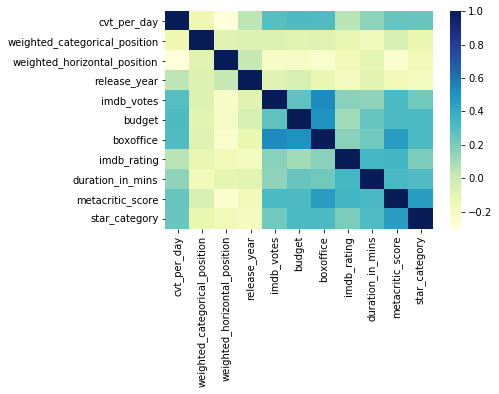

In [59]:
sns.heatmap(corr, cmap="YlGnBu")


In [60]:
corr

,cvt_per_day,weighted_categorical_position,weighted_horizontal_position,release_year,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,star_category
cvt_per_day,1.000,-0.148,-0.302,0.046,0.298,0.316,0.312,0.059,0.152,0.249,0.247
weighted_categorical_position,-0.148,1.000,-0.084,-0.069,-0.064,-0.090,-0.074,-0.116,-0.174,-0.044,-0.123
weighted_horizontal_position,-0.302,-0.084,1.000,0.027,-0.221,-0.211,-0.245,-0.162,-0.102,-0.255,-0.168
release_year,0.046,-0.069,0.027,1.000,-0.083,-0.040,-0.128,-0.199,-0.097,-0.167,-0.198
imdb_votes,0.298,-0.064,-0.221,-0.083,1.000,0.273,0.531,0.163,0.156,0.322,0.225
budget,0.316,-0.090,-0.211,-0.040,0.273,1.000,0.505,0.106,0.251,0.315,0.322
boxoffice,0.312,-0.074,-0.245,-0.128,0.531,0.505,1.000,0.164,0.226,0.465,0.322
imdb_rating,0.059,-0.116,-0.162,-0.199,0.163,0.106,0.164,1.000,0.344,0.347,0.192
duration_in_mins,0.152,-0.174,-0.102,-0.097,0.156,0.251,0.226,0.344,1.000,0.327,0.309
metacritic_score,0.249,-0.044,-0.255,-0.167,0.322,0.315,0.465,0.347,0.327,1.000,0.452


In [66]:
# calculate two features correlation
from scipy.stats import pearsonr
print (pearsonr(df1['weighted_categorical_position'], df1['cvt_per_day'])[0])
# p-value is extremely small

-0.14799969872195723


## 1.3 Understand categorical data

1.3.1 Simple categorical features (import_id, mpaa, awards)

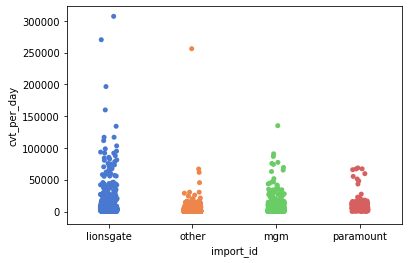

,index,import_id
0,other,2963
1,lionsgate,677
2,mgm,445
3,paramount,141


In [67]:
sns.stripplot(x = 'import_id', y = 'cvt_per_day', data = df1, jitter = True, palette = 'muted')
plt.show()
df1['import_id'].value_counts().reset_index()

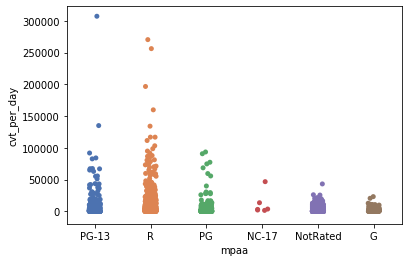

,index,mpaa
0,NotRated,2158
1,R,1158
2,PG-13,426
3,PG,353
4,G,125
5,NC-17,6


In [68]:
sns.stripplot(x = 'mpaa', y = 'cvt_per_day', data = df1, jitter = True, palette = 'deep')
plt.show()
df1['mpaa'].value_counts().reset_index()

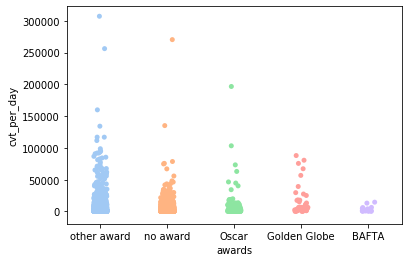

,index,awards
0,no award,2569
1,other award,1453
2,Oscar,141
3,Golden Globe,44
4,BAFTA,19


In [69]:
sns.stripplot(df1['awards'], df1['cvt_per_day'], palette= 'pastel')
plt.show()
df1['awards'].value_counts().reset_index()

1.3.2 Distribution of split genres
 - Some videos belong to more than 1 genre. I split each genre out to help emphasize the effect of each individual genre.

Text(0.5, 0, 'genres')

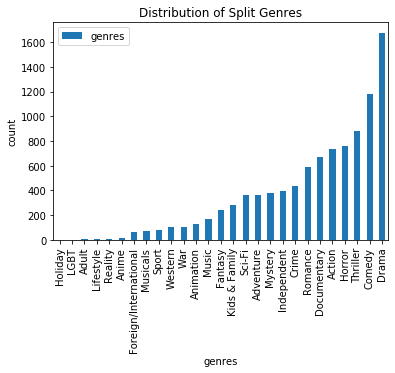

In [31]:
bar_chart = df1['genres'].str.get_dummies(sep=',').sum()
#Series.str.get_dummies: Split each string in the Series by sep and return a DataFrame of dummy/indicator variables. axis : {index (0), columns (1)}
#If the input is index axis then it adds all the values in a column and returns a series containing the sum of all the values in each column.

#Action                    739
#Adult                       3
#Adventure                 363

bar_chart.sort_values(ascending=True).plot.bar(label = 'genres')
plt.title('Distribution of Split Genres')
plt.legend(loc = 'upper left')
plt.ylabel('count')
plt.xlabel('genres')


In [43]:
print('There are ' + str(df1['genres'].str.get_dummies(sep=',').columns.shape[0]) + ' movie genres after splitting')

There are 27 movie genres after splitting


6 genres including Anime, Reality, Lifestyle, Adult, LGBT, Holiday have low frequencies. Therefore, during feature processing, they will be grouped together as: 'Misc_gen' in the feature 'genres'.

1.3.3 Distribution of release_year
 - The release year of video varies through a wide range. Considering the popularity of a video usually decays over time, the release_year should be bucketized based on the release_year range.

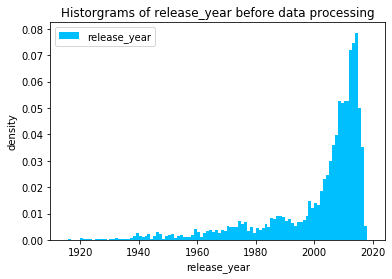

In [44]:
plt.hist(df1['release_year'], density = True, label = 'release_year', bins = range(1915, 2020, 1), color = 'deepskyblue')
plt.legend(loc ='upper left')
plt.title('Historgrams of release_year before data processing')
plt.xlabel('release_year')
plt.ylabel('density')
plt.show()

In [45]:
df1['release_year'].describe(percentiles = [.1, .2, .3, .4, .5, .6, .7, .8, .9])
#split into 10 sub groups

count   4226.000
mean    2001.057
std       17.497
min     1916.000
10%     1974.000
20%     1991.000
30%     2001.000
40%     2006.000
50%     2008.000
60%     2010.000
70%     2012.000
80%     2013.000
90%     2014.000
max     2017.000
Name: release_year, dtype: float64

# Part 2: Feature Processing

## 2.1 Handling missing values

Among the 10 numerical features (not include video_id), 4 features have over 25% of missing values (shown as '0', which is not possible in reality): budget, boxoffice, metacritic_score, star_category. 2 features have less than 10% of missing data: imdb_votes, imdb_rating.

There are 3242 samples have at least one missing data.

In [0]:
# mark zero values as NaN
mv_cols = ['budget', 'boxoffice', 'metacritic_score', 'star_category', 'imdb_votes', 'imdb_rating']
df1[mv_cols] = df1[mv_cols].replace(0, np.nan)

In [47]:
df1.tail()

,video_id,cvt_per_day,weighted_categorical_position,weighted_horizontal_position,import_id,release_year,genres,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,awards,mpaa,star_category
4221,160848,9.726,3,32,other,2010,"Comedy,Drama",14.000,nan,nan,7.800,4.312,nan,no award,NotRated,1.700
4222,365178,7.913,29,35,other,2013,Music,nan,nan,nan,nan,4.879,nan,no award,PG-13,nan
4223,11615,2.936,3,27,other,2008,Comedy,505.000,nan,nan,7.100,110.350,nan,other award,NotRated,nan
4224,26365,2.867,4,15,other,2003,Documentary,5.000,100000.000,nan,6.000,79.633,nan,no award,NotRated,nan
4225,11229,2.188,7,35,other,2003,"Drama,Romance",80.000,nan,nan,7.600,53.618,nan,no award,NotRated,1.750


In [48]:
# count the number of NaN values in each column
df1.isnull().sum()

video_id                            0
cvt_per_day                         0
weighted_categorical_position       0
weighted_horizontal_position        0
import_id                           0
release_year                        0
genres                              0
imdb_votes                        344
budget                           2454
boxoffice                        3194
imdb_rating                       344
duration_in_mins                    0
metacritic_score                 3012
awards                              0
mpaa                                0
star_category                    1846
dtype: int64

In [49]:
#count the number of video that has at least one missing data
print('videos having at least one null: ', df1.isnull().any(axis = 1).sum())

videos having at least one null:  3242


Filling missing data with mean
 - For imdb_voates and imdb_rating, they always show 'null' together, which is reasonable, since when a imdb_votes is missing, the imdb_rating is mostly also missing. For all 6 features with missing data, the 1st attempt is to fill in with their mean value.

In [0]:
df2 = df1.copy()
df2['budget'].fillna(value = df2['budget'].mean(), inplace = True)
df2['boxoffice'].fillna(df2['boxoffice'].mean(), inplace = True)
df2['imdb_rating'].fillna(df2['imdb_rating'].mean(), inplace = True)
df2['imdb_votes'].fillna(df2['imdb_votes'].mean(), inplace = True)
df2['metacritic_score'].fillna(df2['metacritic_score'].mean(), inplace = True)
df2['star_category'].fillna(df2['star_category'].mean(), inplace = True)

df2 has missing data filled in with mean values in columns budget, boxoffice,metacritic_score, star_category, imdb_votes and imdb_rating.
It will be tested in the upcoming models and with variation of median moving forward.

## 2.2 Categorical features

There are 5 categorical features: import_id, mpaa, awards, genres, and release_year. There is no missing data in them. They can be converted into dummy/indicators.

The first 3 have relatively small sub-types, they can be easily converted to dummies.

The 'genres' have 27 different sub-types, 6 of them are rarely observed (refer to previous section). It's reasonable to group these 6 into 1. Note: a video may have more than one genre, in the feature preprocessing, all genres are handled individually.

The release_year is binned into 10 buckets based on the year range between 1917 and 2017.

In [0]:
# Convert 3 categorical features into dummy variables
df3 = df2.copy()
d_import_id = pd.get_dummies(df3['import_id'])
d_mpaa = pd.get_dummies(df3['mpaa'])
d_awards = pd.get_dummies(df3['awards'])

In [0]:
# Convert 'genres' into dummy variables
d_genres = df3['genres'].str.get_dummies(sep=',')

In [57]:
d_genres.shape

(4226, 27)

In [0]:
# combine 6 smallest genres into a new genre 'Misc_gen'. Use bitwise operation '|', then drop these 6 columns.
d_genres['Misc_gen'] = d_genres['Anime']|d_genres['Reality']|d_genres['Lifestyle']|d_genres['Adult']|d_genres['LGBT']|d_genres['Holiday']
d_genres.drop(['Anime', 'Reality','Lifestyle', 'Adult','LGBT','Holiday'], inplace=True, axis=1)

In [58]:
d_genres.shape

(4226, 27)

In [60]:
df3['release_year'].describe(percentiles = [.1, .2, .3, .4, .5, .6, .7, .8, .9])

count   4226.000
mean    2001.057
std       17.497
min     1916.000
10%     1974.000
20%     1991.000
30%     2001.000
40%     2006.000
50%     2008.000
60%     2010.000
70%     2012.000
80%     2013.000
90%     2014.000
max     2017.000
Name: release_year, dtype: float64

In [0]:
# bin release_year into 10 buckets
bin_year = [1916, 1974, 1991, 2001, 2006, 2008, 2010, 2012, 2013, 2014, 2017]
year_label_name = ['1916-1974', '1974-1991', '1991-2001', '2001-2006', '2006-2008', '2008-2010', '2010-2012', '2012-2013', '2013-2014', '2014-2017']
bin_df = pd.cut(df3['release_year'], bin_year, labels = year_label_name) #the value of each row turned from certain year to one of the 10 buckets

In [62]:
bin_df

0       2012-2013
1       2012-2013
2       2010-2012
3       2006-2008
4       2012-2013
          ...    
4221    2008-2010
4222    2012-2013
4223    2006-2008
4224    2001-2006
4225    2001-2006
Name: release_year, Length: 4226, dtype: category
Categories (10, object): [1916-1974 < 1974-1991 < 1991-2001 < 2001-2006 ... 2010-2012 < 2012-2013 <
                          2013-2014 < 2014-2017]

In [0]:
# convert release_year to 10 dummy features
d_year = pd.get_dummies(bin_df)

In [0]:
# drop original categorical cols 
df3_temp = df3.drop(columns = ['import_id', 'mpaa', 'awards', 'genres', 'release_year'], axis = 1)
new_df3 = pd.concat([df3_temp, d_import_id, d_mpaa, d_awards, d_genres, d_year], axis = 1)

In [66]:
# check the shpae of new DataFrame
new_df3.shape

(4226, 58)

In [73]:
# double check missing values
new_df3.isnull().any(axis = 0)

# .any(axis = 0) checks whether any element is True in each column (isnull in this case)

video_id                         False
cvt_per_day                      False
weighted_categorical_position    False
weighted_horizontal_position     False
imdb_votes                       False
budget                           False
boxoffice                        False
imdb_rating                      False
duration_in_mins                 False
metacritic_score                 False
star_category                    False
lionsgate                        False
mgm                              False
other                            False
paramount                        False
G                                False
NC-17                            False
NotRated                         False
PG                               False
PG-13                            False
R                                False
BAFTA                            False
Golden Globe                     False
Oscar                            False
no award                         False
other award              

In [74]:
new_df3.head()

,video_id,cvt_per_day,weighted_categorical_position,weighted_horizontal_position,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,star_category,lionsgate,mgm,other,paramount,G,NC-17,NotRated,PG,PG-13,R,BAFTA,Golden Globe,Oscar,no award,other award,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Fantasy,Foreign/International,Horror,Independent,Kids & Family,Music,Musicals,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,Misc_gen,1916-1974,1974-1991,1991-2001,2001-2006,2006-2008,2008-2010,2010-2012,2012-2013,2013-2014,2014-2017
0,385504,307127.606,1,3,69614.000,15000000.000,42930462.000,6.500,112.301,51.000,1.710,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1,300175,270338.426,1,3,46705.000,15000000.000,3301046.000,6.500,94.983,41.000,3.250,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
2,361899,256165.867,1,3,197596.000,26000000.000,37397291.000,7.300,115.764,58.000,2.647,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,308314,196622.721,3,4,356339.000,15000000.000,15700000.000,7.600,130.704,94.000,1.667,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0
4,307201,159841.652,1,3,46720.000,27220000.000,8551228.000,6.400,105.546,37.000,3.067,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


New_df3 is kept after feature pre-processing. It holds 4226 observations and 58 features. There is NO null data.

## 2.3 Split Train/Test data

80% of the samples will be used to train all the models in the next section. 20% is reserved to test the models in the model evaluation section.

In [0]:
#get ground truth data
y = new_df3['cvt_per_day']
X = new_df3.drop(['cvt_per_day', 'video_id'], axis = 1)

In [127]:
# split the data into training and testing
from sklearn import model_selection

# Reserve 20% for testing
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2)

print('training data has ' + str(X_train.shape[0]) + ' observation with ' + str(X_train.shape[1]) + ' features')
print('testing data has ' + str(X_test.shape[0]) + ' observation with ' + str(X_test.shape[1]) + ' features')

training data has 3380 observation with 56 features
testing data has 846 observation with 56 features


## 2.4 Scaling

The impact of different scaling methods on the model performance is small. In the following model training and selections, the normalized data is used.

In [128]:
X_train.head()

,weighted_categorical_position,weighted_horizontal_position,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,star_category,lionsgate,mgm,other,paramount,G,NC-17,NotRated,PG,PG-13,R,BAFTA,Golden Globe,Oscar,no award,other award,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Fantasy,Foreign/International,Horror,Independent,Kids & Family,Music,Musicals,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,Misc_gen,1916-1974,1974-1991,1991-2001,2001-2006,2006-2008,2008-2010,2010-2012,2012-2013,2013-2014,2014-2017
437,5,16,4976.000,1500000.000,8551228.000,4.800,94.316,57.000,1.062,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3457,7,39,1713.000,5129256.081,10386207.734,3.700,70.510,55.605,1.695,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
28,2,6,34610.000,2000000.000,60755732.000,4.800,113.040,16.000,1.538,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1156,12,36,9751.000,1500000.000,8551228.000,6.400,83.106,63.000,2.500,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2437,4,43,112.000,100000.000,10386207.734,3.800,80.017,55.605,1.695,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [0]:
# MinMax normalization

from sklearn.preprocessing import MinMaxScaler
minmax_scaler = MinMaxScaler()
X_train_minmax = minmax_scaler.fit_transform(X_train)
X_test_minmax = minmax_scaler.transform(X_test)

In [133]:
X_train_minmax[0]

array([0.11764706, 0.2238806 , 0.00524022, 0.01401868, 0.04641456,
       0.42222224, 0.37308406, 0.56842105, 0.02083333, 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        ])

In [0]:
# (Ref) Standardization

from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
X_train_std = std_scaler.fit_transform(X_train)
X_test_std = std_scaler.transform(X_test)

In [0]:
# (Ref) Robust scaling

from sklearn.preprocessing import RobustScaler
robust_scaler = RobustScaler()
X_train_robust = robust_scaler.fit_transform(X_tran)
X_test_robues = robust_scaler.transform(X_test)

# Part 3: Model Training

## 3.1 Linear Models

### 3.1.1 Lasso Linear Regression

Lasso Linear Regression improves the loss function definition of Linear Regression by introducing variance into the formula. I start with Lasso Regression as it can do numerical optimization for Linear Regression

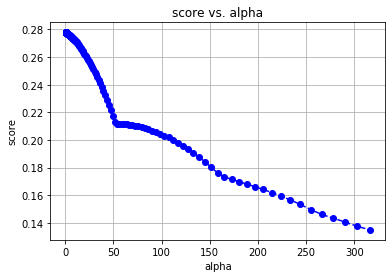

The optimaized alpha and score of Lasso linear Regression is:  0.5011872336272722 0.2779313017728634


In [137]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

#split the training data set into (1) training (2) validation. 
# Tune hyperparameter to find the best hyperparameter with the highest score (R2) on the validation data set.

X_sub_train, X_validate, y_sub_train, y_validate = train_test_split(X_train_minmax, y_train, test_size=0.2, random_state = 0)

alphas = np.logspace (-0.3, 2.5, num=150)
# alphas= [0.000000001]
scores = np.empty_like(alphas) #Return a new array with the same shape and type as the given array alphas
opt_alpha = float('-inf')
max_score = float('-inf')
for idx, alp in enumerate(alphas):
    model_lasso = Lasso()
    model_lasso.set_params(alpha = alp)
    model_lasso.fit(X_sub_train, y_sub_train)
    scores[idx] = model_lasso.score(X_validate, y_validate) #r-squared
    if scores[idx] > max_score:
        max_score = scores[idx]
        opt_alpha = alp
        best_model_lasso = model_lasso
plt.plot(alphas, scores, color='b', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=6)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
print ('The optimaized alpha and score of Lasso Linear Regression is: ', opt_alpha, max_score)

In [139]:
# combine the validate data and training data, use the optimal alpha, re-train the model

model_lasso_final = Lasso()
model_lasso_final.set_params(alpha = opt_alpha)
model_lasso_final.fit(X_train_minmax, y_train)

Lasso(alpha=0.5011872336272722, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

model_lasso_final is the Lasso Linear Regression model to be tested with final test data

#### Lasso Polynomial Regression

To improve the R-squared score of Lasso Linear Regression (0.27), I add polynomial features 

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27955881053.71121, tolerance: 51670009.333155
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27953495656.93566, tolerance: 51670009.333155
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27950010886.02905, tolerance: 51670009.333155
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27945488119.104267

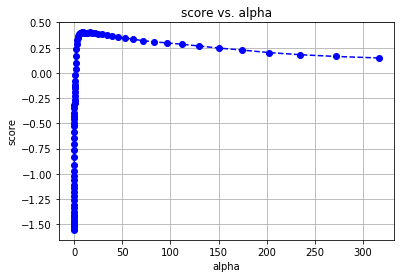

The optimaized alpha and score of Lasso polynomial is:  7.692649574879138 0.4031010344150105


In [150]:
from sklearn.preprocessing import PolynomialFeatures

X_sub_train_, X_validate_, y_sub_train_, y_validate_ = train_test_split(X_train_minmax, y_train, test_size=0.2, random_state = 0)

poly = PolynomialFeatures(2)
X_sub_train_poly2 = poly.fit_transform(X_sub_train_)
X_sub_validate_poly2 = poly.transform(X_validate_)

alphas = np.logspace (-2.6, 2.5, num=80)
# alphas= [1]
scores = np.empty_like(alphas)
opt_alpha = float('-inf')
max_score = float('-inf')
for idx, alp in enumerate(alphas):
    model_lasso_poly = Lasso()
    model_lasso_poly.set_params(alpha = alp)
    model_lasso_poly.fit(X_sub_train_poly2, y_sub_train_)
    scores[idx] = model_lasso_poly.score(X_sub_validate_poly2, y_validate_)
    if scores[idx] > max_score:
        max_score = scores[idx]
        opt_alpha = alp
        best_mode_lasso_poly = model_lasso_poly
        
plt.plot(alphas, scores, color='b', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=6)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
print('The optimaized alpha and score of Lasso polynomial is: ', opt_alpha, max_score)

In [151]:
# combine the validate data and training data, use the optimal alpha, re-train the model
X_train_minmax_poly = poly.fit_transform(X_train_minmax)

model_lasso_poly = Lasso()
model_lasso_poly.set_params(alpha = opt_alpha)
model_lasso_poly.fit(X_train_minmax_poly, y_train)

Lasso(alpha=7.692649574879138, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

model_lasso_poly is the Lasso Polynomial Regression model to be tested with final test data. The r-squared score is 0.40, higher than that of Lasso Linear Regression model (0.27)

### 3.1.2 Ridge Linear Regression

Ridge Linear Regression model is another model that optimizes the loss function 

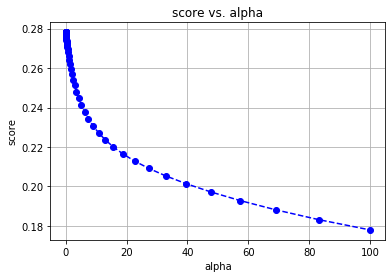

The optimaized alpha and score of Ridge Linear Regression is:  1e-10 0.27817526906421763


In [159]:
#Same with Lasso, split the training data set into (1) training (2) validation and tune hyperparameter

X_sub_train_r, X_validate_r, y_sub_train_r, y_validate_r = train_test_split(X_train_minmax, y_train, test_size=0.2, random_state = 0)

alphas = np.logspace (-10, 2, num=150)
# alphas= [0.000000001]
scores = np.empty_like(alphas)
opt_alpha = float('-inf')
max_score = float('-inf')
for idx, alp in enumerate(alphas):
    model_ridge = Ridge()
    model_ridge.set_params(alpha = alp)
    model_ridge.fit(X_sub_train_r, y_sub_train_r)
    scores[idx] = model_ridge.score(X_validate_r, y_validate_r)
    if scores[idx] > max_score:
        max_score = scores[idx]
        opt_alpha = alp
        best_model_ridge = model_ridge
plt.plot(alphas, scores, color='b', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=6)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
print ('The optimaized alpha and score of Ridge Linear Regression is: ', opt_alpha, max_score)

In [160]:
# combine the validate data and training data, use the optimal alpha, re-train the model

model_ridge_final = Ridge()
model_ridge_final.set_params(alpha = opt_alpha)
model_ridge_final.fit(X_train_minmax, y_train)

Ridge(alpha=1e-10, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

model_ridge_final is the Ridge Linear Regression model to be tested with final test data

#### Ridge Polynomial Regression

To improve the r-squared score of Ridge Linear Regression model (0.27), I add polynomial features

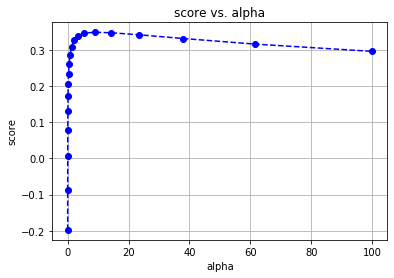

The optimaized alpha and score of Ridge polynomial is:  8.858667904100823 0.34846366820685026


In [161]:
from sklearn.preprocessing import PolynomialFeatures

X_sub_train_rp, X_validate_rp, y_sub_train_rp, y_validate_rp = train_test_split(X_train_minmax, y_train, test_size=0.2, random_state = 0)

poly = PolynomialFeatures(2)
X_sub_train_rpoly2 = poly.fit_transform(X_sub_train_rp)
X_sub_validate_rpoly2 = poly.transform(X_validate_rp)

alphas = np.logspace (-2, 2, num=20)
# alphas= [1]
scores = np.empty_like(alphas)
opt_alpha = float('-inf')
max_score = float('-inf')
for idx, alp in enumerate(alphas):
    model_ridge_poly = Ridge()
    model_ridge_poly.set_params(alpha = alp)
    model_ridge_poly.fit(X_sub_train_rpoly2, y_sub_train_rp)
    scores[idx] = model_ridge_poly.score(X_sub_validate_rpoly2, y_validate_rp)
    if scores[idx] > max_score:
        max_score = scores[idx]
        opt_alpha = alp
        best_mode_ridge_poly = model_ridge_poly
        
plt.plot(alphas, scores, color='b', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=6)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
print('The optimaized alpha and score of Ridge polynomial is: ', opt_alpha, max_score)

In [162]:
# combine the validate data and training data, use the optimal alpha, re-train the model
X_train_minmax_rpoly = poly.fit_transform(X_train_minmax)

model_ridge_poly = Ridge()
model_ridge_poly.set_params(alpha = opt_alpha)
model_ridge_poly.fit(X_train_minmax_rpoly, y_train)

Ridge(alpha=8.858667904100823, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

model_ridge_poly is the Ridge Polynomial Regression model to be tested with final test data. The r-squared score is 0.34, higher than that of Ridge Linear Regression model (0.27)

## 3.2: Non-linear model

Build non-linear model in addition to above mentioned linear models. I'd like to build Random Forest model because it can handle complicated data. Random forest with Gridsearch cross-validation is used. The 'mean_scores' is used to narrow down the paramenters of n_estimator (number of trees in the forest) and Max_depth (maximum depth of the tree).

In [205]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

rf_X_sub_train, rf_X_validation, rf_y_sub_train, rf_y_validation = train_test_split(X_train_minmax, y_train, test_size=0.2, random_state = 0)


param_grid = {
                 'n_estimators': [54, 55, 56, 57, 58, 59, 60, 62],
                 'max_depth': [12, 13, 14, 15, 16, 17]
             }

rf = RandomForestRegressor(random_state=2, max_features = 'sqrt')
grid_rf = GridSearchCV(rf, param_grid, cv=5, scoring = 'r2')
grid_rf.fit(rf_X_sub_train, rf_y_sub_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='sqrt',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=2,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=

In [206]:
grid_rf.best_params_

{'max_depth': 17, 'n_estimators': 55}

In [207]:
grid_rf.cv_results_

{'mean_fit_time': array([0.18570328, 0.1783124 , 0.18353772, 0.19607329, 0.19601889,
        0.20015593, 0.20473399, 0.20839925, 0.19247289, 0.19323697,
        0.20414515, 0.20228662, 0.2004746 , 0.20487037, 0.21423788,
        0.2206841 , 0.20187292, 0.20212002, 0.20825539, 0.21765156,
        0.21129436, 0.21211753, 0.22192283, 0.23432107, 0.20866604,
        0.2063796 , 0.21901484, 0.22389116, 0.23379259, 0.23347297,
        0.23819537, 0.24185557, 0.21035748, 0.22223964, 0.22703757,
        0.23107972, 0.22905388, 0.22765679, 0.23401923, 0.24690013,
        0.22715411, 0.23358302, 0.23542924, 0.23788714, 0.24191709,
        0.24537196, 0.24454203, 0.26220107]),
 'mean_score_time': array([0.00760994, 0.0074831 , 0.00786614, 0.0082912 , 0.00831456,
        0.00865512, 0.00880198, 0.00872111, 0.00801816, 0.00841522,
        0.00978389, 0.00846543, 0.00840359, 0.00859604, 0.00927582,
        0.00916643, 0.0085146 , 0.00834827, 0.00915599, 0.00902772,
        0.00860476, 0.00921907, 0.

In [208]:
#Mean cross-validated score of the best_estimator
grid_rf.best_score_

0.5125563933482997

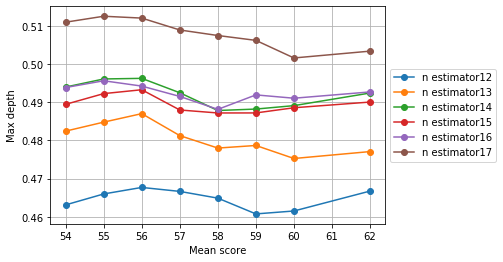

In [209]:
# plot the effect of different number of trees and maximum tree-depth druing cross validation 
scores = grid_rf.cv_results_['mean_test_score']

n_est = [54, 55, 56, 57, 58, 59, 60, 62]
m_depth=[12, 13, 14, 15, 16, 17]
scores = np.array(scores).reshape(len(m_depth), len(n_est))
fig = plt.figure()
ax = plt.subplot(111)
for idx, depth in enumerate(m_depth):
    plt.plot(n_est, scores[idx], '-o', label = 'n estimator' + str(depth))
    
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Mean score')
plt.ylabel('Max depth')
plt.grid(True)
plt.show()

In [210]:
# add both training and validation data together as the new training data
random_forest_final = RandomForestRegressor(random_state=2, max_features = 'sqrt', max_depth= 17, n_estimators=55)
random_forest_final.fit(X_train_minmax, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=17, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=55, n_jobs=None, oob_score=False,
                      random_state=2, verbose=0, warm_start=False)

random_forest_final is the best Random Forest model, with n_estimator = 17 and max_depth = 55. Its r-squared score is 0.51, the best score among the 5 models built:
- model_lasso_final
- model_lasso_poly
- model_ridge_final
- model_ridge_poly
- random_forest_final

All 5 models will be evaluated in the next step.

# Part 4: Model Evaluation

Test data is the reserved 20% of the whole dataset, and has never been seen by the above models. I will use the test data for model evaluation.

## 4.1 Lasso test with linear features (model_lasso_final)

In [213]:
# model_lasso_final test (with linear features)

r2score_lasso = model_lasso_final.score(X_test_minmax, y_test)

# The mean squared error and root mean square error
y_pred_lasso = model_lasso_final.predict(X_test_minmax)
MSE_lasso = mean_squared_error(y_test, y_pred_lasso)
RMSE_lasso = sqrt(mean_squared_error(y_test, y_pred_lasso))

print('Lasso linear regression model') 
print('Score (accuracy): \t', r2score_lasso)
print('Mean square error: \t', MSE_lasso)
print('Root mean squared error: ', RMSE_lasso)
#print('Coefficients of Lasso: ', model_lasso_final.coef_)

Lasso linear regression model
Score (accuracy): 	 0.249264425978332
Mean square error: 	 72422275.54707205
Root mean squared error:  8510.12782201725


## 4.2 Lasso test with polynomial features (model_lasso_poly)

In [214]:
# model_lasso_poly test (with polynomial features)

X_test_minmax_poly = poly.transform(X_test_minmax)

r2score_lasso_poly = model_lasso_poly.score(X_test_minmax_poly, y_test)

# The mean squared error and root mean square error
y_pred_lasso_poly = model_lasso_poly.predict(X_test_minmax_poly)
MSE_lasso_poly = mean_squared_error(y_test, y_pred_lasso_poly)
RMSE_lasso_poly = sqrt(mean_squared_error(y_test, y_pred_lasso_poly))

print('Lasso polynomial regression model') 
print('Score (accuracy): \t', r2score_lasso_poly)
print('Mean square error: \t', MSE_lasso_poly)
print('Root mean squared error: ', RMSE_lasso_poly)
#print('Coefficients of Lasso polynomial regression model: ', model_lasso_poly.coef_)

Lasso polynomial regression model
Score (accuracy): 	 0.3718931427060096
Mean square error: 	 60592476.85342524
Root mean squared error:  7784.116960415307


## 4.3 Ridge test with linear features (model_ridge_final)

In [215]:
# model_ridge_final test (with linear features)

r2score_ridge = model_ridge_final.score(X_test_minmax, y_test)

# The mean squared error and root mean square error
y_pred_ridge = model_ridge_final.predict(X_test_minmax)
MSE_ridge = mean_squared_error(y_test, y_pred_ridge)
RMSE_ridge = sqrt(mean_squared_error(y_test, y_pred_ridge))

print('Ridge linear regression model') 
print('Score (accuracy): \t', r2score_ridge)
print('Mean square error: \t', MSE_ridge)
print('Root mean squared error: ', RMSE_ridge)
#print('Coefficients of Ridge: ', model_ridge_final.coef_)

Ridge linear regression model
Score (accuracy): 	 0.24871050984061768
Mean square error: 	 72475710.96234165
Root mean squared error:  8513.266762080328


## 4.4 Ridge test with polynomial features (model_ridge_poly)

In [217]:
# model_ridge_poly test (with polynomial features)

X_test_minmax_poly_r = poly.transform(X_test_minmax)

r2score_ridge_poly = model_ridge_poly.score(X_test_minmax_poly_r, y_test)

# The mean squared error and root mean square error
y_pred_ridge_poly = model_ridge_poly.predict(X_test_minmax_poly_r)
MSE_ridge_poly = mean_squared_error(y_test, y_pred_ridge_poly)
RMSE_ridge_poly = sqrt(mean_squared_error(y_test, y_pred_ridge_poly))

print('Ridge polynomial regression model') 
print('Score (accuracy): \t', r2score_ridge_poly)
print('Mean square error: \t', MSE_ridge_poly)
print('Root mean squared error: ', RMSE_ridge_poly)
#print('Coefficients of Ridge polynomial regression model: ', model_ridge_poly.coef_)

Ridge polynomial regression model
Score (accuracy): 	 0.30666294281408757
Mean square error: 	 66885131.25004109
Root mean squared error:  8178.333036141356


## 4.5 Random forest test (random_forest_final)

In [216]:
r2score_random_forest = random_forest_final.score(X_test_minmax, y_test)

y_pred_random_forest = random_forest_final.predict(X_test_minmax)
MSE_random_forest = mean_squared_error(y_test, y_pred_random_forest)
RMSE_random_forest = sqrt(mean_squared_error(y_test, y_pred_random_forest))

# The mean squared error and root mean square error
print('Score (accuracy): \t', r2score_random_forest)
print('Mean square error : \t', MSE_random_forest)
print('Root mean squared error', RMSE_random_forest)

Score (accuracy): 	 0.4879098014313143
Mean square error : 	 49400532.955996275
Root mean squared error 7028.551270069549


## 4.6 Comparison of the 5 models

Compared the score, mean squared error (MSE), and root mean squared error (RMSE) of 5 models. Random forest model delivers the best prediction accuracy.

No handles with labels found to put in legend.


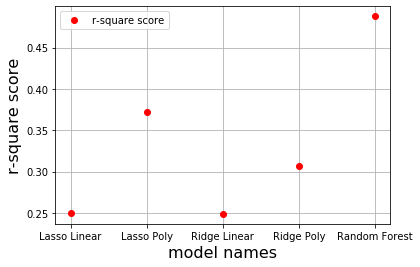

No handles with labels found to put in legend.


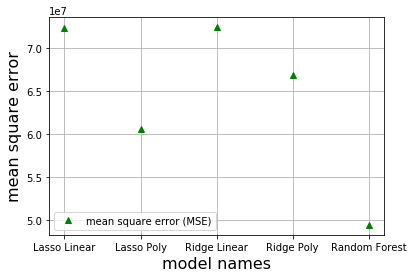

No handles with labels found to put in legend.


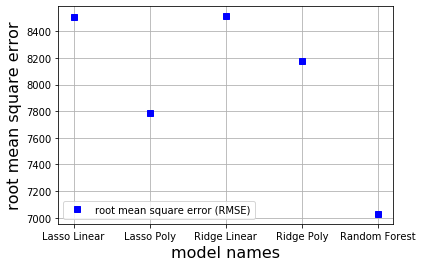

In [222]:
score_lst = [r2score_lasso, r2score_lasso_poly, r2score_ridge, r2score_ridge_poly, r2score_random_forest]
MSE_lst =  [MSE_lasso, MSE_lasso_poly, MSE_ridge, MSE_ridge_poly, MSE_random_forest]
RMSE_lst =  [RMSE_lasso, RMSE_lasso_poly, RMSE_ridge, RMSE_ridge_poly, RMSE_random_forest]
model_lst = ['Lasso Linear','Lasso Poly', 'Ridge Linear', 'Ridge Poly', 'Random Forest']

plt.figure(1)
plt.plot(model_lst, score_lst, 'ro')
plt.legend(loc = 9)
plt.legend(['r-square score'])
plt.xlabel('model names',fontsize =16)
plt.ylabel('r-square score', fontsize =16)
plt.grid(True)
plt.show()

plt.figure(2)
plt.plot(model_lst, MSE_lst, 'g^')
plt.legend(loc = 9)
plt.legend(['mean square error (MSE)'])
plt.xlabel('model names', fontsize =16)
plt.ylabel('mean square error', fontsize =16)
plt.grid(True)
plt.show()

plt.figure(3)
plt.plot(model_lst, RMSE_lst, 'bs')
plt.legend(loc = 9)
plt.legend(['root mean square error (RMSE)'])
plt.xlabel('model names', fontsize =16)
plt.ylabel('root mean square error', fontsize =16)
plt.grid(True)
plt.show()

# Part 5: Feature Selection

The Random Forest model shows the best prediction accuracy. Therefore, the feature importance will be extracted from the RF model.

In [0]:
importances = random_forest_final.feature_importances_
std = np.std([tree.feature_importances_ for tree in random_forest_final.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
feature_name = X_test.columns

In [229]:
print("Feature importance ranking:")

for f in range(X_test.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f],  feature_name[f], importances[indices[f]]))

Feature importance ranking:
1. feature 0 weighted_categorical_position (0.171339)
2. feature 1 weighted_horizontal_position (0.128160)
3. feature 2 imdb_votes (0.124944)
4. feature 4 budget (0.066316)
5. feature 3 boxoffice (0.062998)
6. feature 8 imdb_rating (0.055341)
7. feature 7 duration_in_mins (0.047735)
8. feature 9 metacritic_score (0.045600)
9. feature 6 star_category (0.042235)
10. feature 5 lionsgate (0.036627)
11. feature 53 mgm (0.026348)
12. feature 11 other (0.017847)
13. feature 42 paramount (0.017101)
14. feature 10 G (0.011026)
15. feature 18 NC-17 (0.010147)
16. feature 24 NotRated (0.008223)
17. feature 22 PG (0.006968)
18. feature 49 PG-13 (0.006613)
19. feature 38 R (0.006589)
20. feature 30 BAFTA (0.006436)
21. feature 23 Golden Globe (0.006347)
22. feature 28 Oscar (0.006312)
23. feature 27 no award (0.006170)
24. feature 17 other award (0.006004)
25. feature 43 Action (0.005794)
26. feature 44 Adventure (0.005698)
27. feature 48 Animation (0.005368)
28. feature

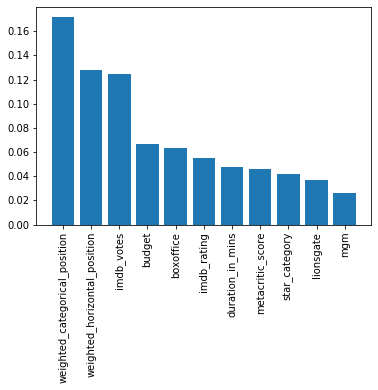

In [230]:
# Print the feature ranking
plt.bar(feature_name[:11], importances[indices[:11]])
plt.xticks(rotation=90)
plt.show()

From the features ranking, top influencing features include position, imdb_votest, budget, boxoffice and imdb_rating. These factors should be considered as key drivers as far as the forecasting dependent, cumulated view time per day, is concerned.

It is to our surprise that the release years appear not so critical as they rank at the bottom of all features. Therefore it is suggested that the platform doesn't necessarily have to buy new movies to increase view time. Buying older movie can do just as well and can save money if other features that rank higher are emphasized.
